<p style="font-weight:bold; font-size:200%"> Root New </p>

- Author: Yichen Luo
- Date: 20220825

In [16]:
import pandas as pd
import threading
import requests
import time
import os
import datetime
import re
import string
import random
import numpy as np
import seaborn as sns;sns.set_theme(color_codes=True)
from web3 import Web3
from hexbytes import HexBytes

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from IPython.core.interactiveshell import InteractiveShell
pd.set_option('max_colwidth', 100)
pd.set_option('display.max_columns', 100)

RD = '/home/team_defi/02_rdata/'
WD = '/home/team_defi/03_wdata/'
RES = '/home/team_defi/04_result/'
InteractiveShell.ast_node_interactivity = 'all'

# Function

In [2]:
def chain_info(chain):
    dexes = {'ethereum':['uniswapv3_ethereum', 'uniswapv2_ethereum', 'sushiswap_ethereum'],
             'binance':['pancake_binance', 'biswap_binance', 'apeswap_binance', 'babyswap_binance', 'jetswap_binance'],
             'avalanche':['traderjoe_avalanche', 'pangolin_avalanche'],
             'fantom':['spookyswap_fantom', 'spiritswap_fantom'],
             'polygon':['sushiswap_polygon', 'apeswap_polygon', 'jetswap_polygon']
            }
    
    dex = dexes[chain]
    return dex

In [3]:
def insider_transaction(address, dex):
    

    dfs = []
    for role in dex_info(dex)['role']:

        post = {"query":dex_info(dex)['post'].substitute({'role': role, 'address':address})}
        url = dex_info(dex)['url']

        r = requests.post(url, json=post)
        data = r.json()
        df = pd.DataFrame.from_dict(data['data']['swaps'])

        if df.shape[0] == 0:
            continue

        if dex_info(dex)['style'] == 0:
            df['token0_name'] = df['token0'].apply(lambda x: x['name'])
            df['token1_name'] = df['token1'].apply(lambda x: x['name'])
            df['token0_id'] = df['token0'].apply(lambda x: x['id'])
            df['token1_id'] = df['token1'].apply(lambda x: x['id'])
            df['transaction_id'] = df['transaction'].apply(lambda x: x['id'])
            df.drop(columns=['token0', 'token1', 'transaction'], inplace=True)
        else:
            if dex_info(dex)['style'] == 1:
                df['token0_name'] = df['pair'].apply(lambda x: x['token0']['name'])
                df['token1_name'] = df['pair'].apply(lambda x: x['token1']['name'])
                df['token0_id'] = df['pair'].apply(lambda x: x['token0']['id'])
                df['token1_id'] = df['pair'].apply(lambda x: x['token1']['id'])
                df['transaction_id'] = df['transaction'].apply(lambda x: x['id'])
                df.drop(columns=['pair', 'transaction'], inplace=True)
        
        df['timestamp'] = pd.to_datetime(df['timestamp'],unit='s', origin='unix')
        
        if dex == 'uniswapv3_ethereum': df = uniswapv3_correction(df)
        
        df = df.loc[df[role] == address]
        if df.shape[0] == 0:
            continue

        dfs.append(df)

    if len(dfs) != 0: 
        dfs = pd.concat(dfs)
        dfs.drop_duplicates('id', inplace=True)

    return dfs

In [4]:
def uniswapv3_correction(df):
    
    df['amount0'] = df['amount0'].astype('float')
    df['amount1'] = df['amount1'].astype('float')
    for idx, row in df.iterrows():
        if row['amount0'] > 0:
            df.loc[df['id'] == row['id'], 'amount0Out'] = 0
            df.loc[df['id'] == row['id'], 'amount0In'] = abs(row['amount0'])
            df.loc[df['id'] == row['id'], 'amount1Out'] = abs(row['amount1'])
            df.loc[df['id'] == row['id'], 'amount1In'] = 0

        else:
            df.loc[df['id'] == row['id'], 'amount0Out'] = abs(row['amount0'])
            df.loc[df['id'] == row['id'], 'amount0In'] = 0
            df.loc[df['id'] == row['id'], 'amount1Out'] = 0
            df.loc[df['id'] == row['id'], 'amount1In'] = abs(row['amount1'])
    df.drop(columns=['amount1', 'amount0'], inplace=True)
    return df

In [5]:
def home_token_filter(df, insider_contractAddress):
    df['home_token'] = False
    df.loc[(df['token0_id'] == insider_contractAddress)|(df['token1_id'] == insider_contractAddress), 'home_token'] = True
    return df

In [6]:
def dex_info(dex):
    dex_infos = {
                'uniswapv3_ethereum':{'url': 'https://api.thegraph.com/subgraphs/name/ianlapham/uniswap-v3-subgraph',
                                       'role': 1,
                                       'style': 0,
                                       'post': 1
                                      },
                
                'uniswapv2_ethereum':{'url': 'https://api.thegraph.com/subgraphs/name/ianlapham/uniswapv2',
                                       'role': 0,
                                       'style': 1,
                                       'post': 0
                                      },
        
                'sushiswap_ethereum':{'url': 'https://api.thegraph.com/subgraphs/name/sushiswap/exchange',
                                       'role': 2,
                                       'style': 1,
                                       'post': 2
                                      },
        
                'pancake_binance':{'url': 'https://bsc.streamingfast.io/subgraphs/name/pancakeswap/exchange-v2',
                                       'role': 0,
                                       'style': 1,
                                       'post': 0
                                      },
        
                'biswap_binance':{'url': 'https://api.thegraph.com/subgraphs/name/biswapcom/exchange5',
                                       'role': 0,
                                       'style': 1,
                                       'post': 0
                                      },
        
                'apeswap_binance':{'url': 'https://graph2.apeswap.finance/subgraphs/name/ape-swap/apeswap-subgraph',
                                       'role': 0,
                                       'style': 1,
                                       'post': 0
                                      },
        
                'babyswap_binance':{'url': 'https://api.thegraph.com/subgraphs/name/loremboard/bsc-babyswap-subgraph',
                                       'role': 0,
                                       'style': 1,
                                       'post': 0
                                      },
        
                'jetswap_binance':{'url': 'https://api.thegraph.com/subgraphs/name/smartcookie0501/jetswap-subgraph-v2',
                                       'role': 0,
                                       'style': 1,
                                       'post': 0
                                      },
        
                'traderjoe_avalanche':{'url': 'https://api.thegraph.com/subgraphs/name/traderjoe-xyz/exchange',
                                       'role': 2,
                                       'style': 1,
                                       'post': 2
                                      }, 
        
                'pangolin_avalanche':{'url': 'https://api.thegraph.com/subgraphs/name/dasconnor/pangolin-dex',
                                       'role': 0,
                                       'style': 1,
                                       'post': 0
                                      },  
        
                'spookyswap_fantom':{'url': 'https://api.thegraph.com/subgraphs/name/int3grtor/spooky-exchange',
                                       'role': 2,
                                       'style': 1,
                                       'post': 2
                                      },  
        
                'spiritswap_fantom':{'url': 'https://api.thegraph.com/subgraphs/name/evele/spirit-swap-subgraph-dev-v2',
                                       'role': 2,
                                       'style': 1,
                                       'post': 2
                                      },  
        
                'sushiswap_polygon':{'url': 'https://api.thegraph.com/subgraphs/name/sushiswap/matic-exchange',
                                       'role': 2,
                                       'style': 1,
                                       'post': 2
                                      },
        
                'apeswap_polygon':{'url': 'https://api.thegraph.com/subgraphs/name/apeswapfinance/dex-polygon',
                                       'role': 0,
                                       'style': 1,
                                       'post': 0
                                      },
        
                'jetswap_polygon':{'url': 'https://api.thegraph.com/subgraphs/name/smartcookie0501/jetswap-subgraph-polygon-v2',
                                       'role': 0,
                                       'style': 1,
                                       'post': 0
                                      },
                }
    
    roles = [['from', 'to', 'sender'],
             ['origin', 'recipient', 'sender'],
             ['sender', 'to']]
    
    url = dex_infos[dex]['url']
    role = roles[dex_infos[dex]['role']]
    style = dex_infos[dex]['style']
    post = dex_infos[dex]['post']
    
    info = {'url':url,
            'post':post_string(post),
            'role':role,
            'style':style
           }

    return info

In [7]:
def post_string(post):
    if post == 0:
        query = string.Template("""query MyQuery {
  swaps(first: 1000, where: {$role: "$address"}) {
    amount0In
    amount0Out
    amount1In
    amount1Out
    amountUSD
    from
    id
    logIndex
    to
    timestamp
    sender
    pair {
      token0 {
        id
        name
      }
      token1 {
        id
        name
      }
    }
    transaction {
      id
    }
  }
}""")
        
    if post == 1:
        query = string.Template("""query MyQuery {
  swaps(first: 1000, where: {$role: "$address"}) {
    amount0
    amount1
    amountUSD
    id
    logIndex
    origin
    recipient
    sender
    sqrtPriceX96
    tick
    timestamp
    token0 {
      id
      name
    }
    token1 {
      id
      name
    }
    transaction {
      id
    }
  }
}""")
        
    if post == 2:
        query = string.Template("""query MyQuery {
  swaps(first: 1000, where: {$role: "$address"}) {
    amount0In
    amount0Out
    amount1In
    amount1Out
    amountUSD
    id
    logIndex
    sender
    timestamp
    to
    pair {
      token0 {
        id
        name
      }
      token1 {
        id
        name
      }
    }
    transaction {
      id
    }
  }
}""")
    return query

In [8]:
def liquidity_provision(transaction_id, chain):
    
    time.sleep(1 + random.random() * 2)
    headers = {'user-agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/100.0.4896.75 Safari/537.36'}

    if chain == 'ethereum': url = f'https://etherscan.io/tx/{transaction_id}'
    if chain == 'binance' : url = f'https://bscscan.com/tx/{transaction_id}'
    if chain == 'avalanche': url = f'https://snowtrace.io/tx/{transaction_id}'
    if chain == 'polygon' : url = f'https://polygonscan.com/tx/{transaction_id}'
    if chain == 'fantom' : url = f'https://ftmscan.com/tx/{transaction_id}'

    r = requests.get(url, headers=headers)
    if re.search('liquidity to', r.text.lower()) != None:
        return True
    else:
        return False

In [9]:
def token_first_day(contract, chain):
    
        contractAddress_lower = contract.lower()
        contractAddress_upper = Web3.toChecksumAddress(contractAddress_lower)
        dfs = []
        dex_num = 0

        for dex in chain_info(chain):
            lst = pd.read_csv(f'{WD}/dex_price/list_all/{dex}.csv')
            csv_info = lst.loc[((lst['contractAddress'] == contractAddress_lower)|
                                (lst['contractAddress'] == contractAddress_upper))]
            
            if csv_info['contractAddress'].values[0] == contractAddress_lower:
                contractAddress = contractAddress_lower
            else:
                contractAddress = contractAddress_upper

            status = csv_info['status'].values[0]
            dexn = csv_info['dex'].values[0]

            if status == 0: 
                continue
            elif dexn == 0:
                continue
            else:
                csv = pd.read_csv(f'{WD}dex_price/csv_all/{contractAddress}_{dex}.csv') 
                csv['dex'] = dex
                dex_num += 1
                dfs.append(csv)
                
        dfs = pd.concat(dfs)
        
        first = dfs['date'].min()

        return first

# List

In [7]:
# chains = ['ethereum', 'binance', 'avalanche', 'fantom', 'polygon']
# dfs = []
# for chain in chains:
#     for dex in chain_info(chain):
#         df = pd.read_csv(f'/home/yichen/team_defi/04_result/insider_trading/root_list/root_list_final/root_{chain}.csv')
#         df['status'] = -1
#         df['chain'] = chain
#         df
#         df.to_csv(f'{WD}root_new/list/{dex}.csv', index=False)

In [145]:
chains = ['ethereum', 'binance', 'avalanche', 'fantom', 'polygon']
dfs = []
for chain in chains:
    df = pd.read_csv(f'/home/yichen/team_defi/04_result/insider_trading/root_list/root_list_final/root_{chain}.csv')
    chain
    df['root'].nunique()
    df['contractAddress'].nunique()

'ethereum'

8064

7743

'binance'

5857

4920

'avalanche'

840

807

'fantom'

17

12

'polygon'

29

27

# Threading

In [80]:
class web_thread(threading.Thread):
    
    def __init__ (self, dex):
        threading.Thread.__init__(self)
        self.dex = dex
        
    def run(self):
        RD = '/home/team_defi/02_rdata/'
        WD = '/home/team_defi/03_wdata/'
        RES = '/home/team_defi/04_result/'
        
        lst = pd.read_csv(f'{WD}root_new/list/{self.dex}.csv')
        
        done = lst.loc[lst['status'] != -1].shape[0]
        total = lst.shape[0]
        
        for idx, row in lst.loc[lst['status'] == -1].iterrows():
            root = row['root']
            contractAddress = row['contractAddress']
            chain = row['chain']
            
            try:
                done += 1
                
                dfs = insider_transaction(address=root, dex=self.dex)
                
                if len(dfs) == 0:
                    lst.loc[lst['root'] == root, 'status'] = 0
                    print(f'{root}, {self.dex} no swap, {done}/{total}')
                else:
                    dfs.to_csv(f'{WD}root_new/csv/{root}_{self.dex}.csv', index=False)
                    length = dfs.shape[0]
                    lst.loc[lst['root'] == root, 'status'] = length
                    print(f'{root}, {self.dex} find {length} swap, {done}/{total}')
                
                lst.to_csv(f'{WD}root_new/list/{self.dex}.csv', index=False)
                
            except Exception as e:
                time.sleep(2)
                print(f'{root}, {self.dex}, Error: {e}')
                
        print(f'{self.dex} done')

In [81]:
thread1 = web_thread('uniswapv3_ethereum')
thread2 = web_thread('uniswapv2_ethereum')
thread3 = web_thread('sushiswap_ethereum')

thread4 = web_thread('pancake_binance')
thread5 = web_thread('biswap_binance')
thread6 = web_thread('apeswap_binance')
thread7 = web_thread('babyswap_binance')
thread8 = web_thread('jetswap_binance')

thread9 = web_thread('traderjoe_avalanche')
thread10 = web_thread('pangolin_avalanche')

thread11 = web_thread('sushiswap_polygon')
thread12 = web_thread('apeswap_polygon')
thread13 = web_thread('jetswap_polygon')

thread14 = web_thread('spookyswap_fantom')
thread15 = web_thread('spiritswap_fantom')

In [ ]:
Threads = [
           thread1, 
           thread2, 
           thread3,
           thread4,
           thread5,
           thread6,
           thread7,
           thread8,
           thread9,
           thread10,
           thread11,
           thread12,
           thread13,
           thread14,
           thread15,
          ]
for t in Threads:
    t.start()
for t in Threads:
    t.join()

uniswapv3_ethereum done
biswap_binance done
apeswap_binance done
sushiswap_ethereum done
traderjoe_avalanche done
babyswap_binance done
pangolin_avalanche done
uniswapv2_ethereum done
sushiswap_polygon done
apeswap_polygon done
jetswap_polygon done
spookyswap_fantom done
jetswap_binance done
spiritswap_fantom done
0x57b85ec48b6c8acf7fc396d459d1c71f8a6064bf, pancake_binance, Error: 'data'
0xf932898312ae2bdc1de32d140b7c9a647cabdd8d, pancake_binance, Error: 'data'
0xca7018f81d0375a5e95392c0bdf1aa744b02956c, pancake_binance, Error: 'data'
0xb1e3ad564eb6971a673e829684d5ddc246f44271, pancake_binance, Error: 'data'
0xb98a7de1edcbb5793862fa16185db4dbad60c1da, pancake_binance, Error: 'data'
0x2eb34fb69b2c6125d8599169d17c19b1c393fbfa, pancake_binance, Error: 'data'
0x8e67ed97baa8e7dbefd8f7adf7b1301e4b961eda, pancake_binance, Error: 'data'
0x70537a25588b8e99a9a0d984566da4f8fc11841b, pancake_binance, Error: 'data'
0x2763d45659147e17d31002e4e1d6dfbfa59c3a03, pancake_binance, Error: 'data'
0xc4b7aea

# Home Token

In [13]:
for chain in ['ethereum', 'binance', 'avalanche', 'polygon', 'fantom']:
    dfs = []
    
    for dex in chain_info(chain):

        
        lst = pd.read_csv(f'{WD}root_new/list/{dex}.csv')
        
        total = lst.loc[lst['status'] > 0].shape[0]
        num = 0
        
        for idx, row in lst.loc[lst['status'] > 0].iterrows():
            num += 1
            print(f'{dex}, {num}/{total}')
            root = row['root']
            contractAddress = row['contractAddress']
            
            
            df = pd.read_csv(f'{WD}root_new/csv/{root}_{dex}.csv')
            df = home_token_filter(df, contractAddress)
            df = df.loc[df['home_token'] == True]
            
            if df.shape[0] != 0:
                df['dex'] = dex
                df['chain'] = chain
                df['insider_root'] = root
                df['contractAddress'] = contractAddress
                dfs.append(df)
                
                
    if len(dfs) != 0:
        dfs = pd.concat(dfs)
        dfs.to_csv(f'{WD}root_new/list_lp/{chain}.csv', index=False)

uniswapv3_ethereum, 1/815
uniswapv3_ethereum, 2/815
uniswapv3_ethereum, 3/815
uniswapv3_ethereum, 4/815
uniswapv3_ethereum, 5/815
uniswapv3_ethereum, 6/815
uniswapv3_ethereum, 7/815
uniswapv3_ethereum, 8/815
uniswapv3_ethereum, 9/815
uniswapv3_ethereum, 10/815
uniswapv3_ethereum, 11/815
uniswapv3_ethereum, 12/815
uniswapv3_ethereum, 13/815
uniswapv3_ethereum, 14/815
uniswapv3_ethereum, 15/815
uniswapv3_ethereum, 16/815
uniswapv3_ethereum, 17/815
uniswapv3_ethereum, 18/815
uniswapv3_ethereum, 19/815
uniswapv3_ethereum, 20/815
uniswapv3_ethereum, 21/815
uniswapv3_ethereum, 22/815
uniswapv3_ethereum, 23/815
uniswapv3_ethereum, 24/815
uniswapv3_ethereum, 25/815
uniswapv3_ethereum, 26/815
uniswapv3_ethereum, 27/815
uniswapv3_ethereum, 28/815
uniswapv3_ethereum, 29/815
uniswapv3_ethereum, 30/815
uniswapv3_ethereum, 31/815
uniswapv3_ethereum, 32/815
uniswapv3_ethereum, 33/815
uniswapv3_ethereum, 34/815
uniswapv3_ethereum, 35/815
uniswapv3_ethereum, 36/815
uniswapv3_ethereum, 37/815
uniswapv3_

In [15]:
dfs = []
for chain in ['ethereum', 'binance', 'avalanche', 'fantom', 'polygon']:   
    df = pd.read_csv(f'{WD}root_new/list_lp/{chain}.csv')
    df
    dfs.append(df)
    
dfs = pd.concat(dfs)
dfs.to_csv(f'{WD}root_new/list_lp/panel.csv')

,amountUSD,id,logIndex,origin,recipient,sender,sqrtPriceX96,tick,timestamp,token0_name,token1_name,token0_id,token1_id,transaction_id,amount0Out,amount0In,amount1Out,amount1In,home_token,dex,chain,insider_root,contractAddress,from,to
0,209.294150,0xe91b835550a1a50b26a0646fa3e1def942a78ea5ce7349529a30700eff08ab11#33823,266,0x008295a98dcd428b680bc1db7a743f1d3993b4d4,0x008295a98dcd428b680bc1db7a743f1d3993b4d4,0xe592427a0aece92de3edee1f18e0157c05861564,9400732126353364784919992,-180796.0,2021-11-22 02:43:11,Tiger King,Wrapped Ether,0x24e89bdf2f65326b94e36978a7edeac63623dafa,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0xe91b835550a1a50b26a0646fa3e1def942a78ea5ce7349529a30700eff08ab11,3.541485e+06,0.000000,0.000000,0.050000,True,uniswapv3_ethereum,ethereum,0x008295a98dcd428b680bc1db7a743f1d3993b4d4,0x24e89bdf2f65326b94e36978a7edeac63623dafa,NaN,NaN
1,439.630640,0xd1644c62998cbb5fa03b412ab9c62cd560706e04d2399fd86860fcd10159c499#4,100,0x240bf95c3df6fc0206028a073555e251aa67458b,0x240bf95c3df6fc0206028a073555e251aa67458b,0xe592427a0aece92de3edee1f18e0157c05861564,792833476219372735929747753,-92095.0,2021-09-07 22:15:51,TRIBE,Wrapped Ether,0x4ffcad848248d4931374336fcaccf263638413ae,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0xd1644c62998cbb5fa03b412ab9c62cd560706e04d2399fd86860fcd10159c499,1.294447e+03,0.000000,0.000000,0.130000,True,uniswapv3_ethereum,ethereum,0x240bf95c3df6fc0206028a073555e251aa67458b,0x4ffcad848248d4931374336fcaccf263638413ae,NaN,NaN
2,325.499103,0x099a3083fd9a904646021f522bef9d887e6ab07b5171a59ca278c4edce13c43b#546,282,0xd42b6798e0ea3c455aa31a15e8e582439154e5cc,0xd42b6798e0ea3c455aa31a15e8e582439154e5cc,0xe592427a0aece92de3edee1f18e0157c05861564,108654985078874190449425007,-131845.0,2021-08-17 22:21:44,INCH TOKEN,USD Coin,0x6339bd92eaa3cb8e629b06449e08b90581a33cea,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0x099a3083fd9a904646021f522bef9d887e6ab07b5171a59ca278c4edce13c43b,0.000000e+00,170035.300000,325.499103,0.000000,True,uniswapv3_ethereum,ethereum,0xd42b6798e0ea3c455aa31a15e8e582439154e5cc,0x6339bd92eaa3cb8e629b06449e08b90581a33cea,NaN,NaN
3,235.663410,0x2f9ee0617b0024f000eda6cef85507776e2b7d2f2f637858764eb2c652f6c40e#619,133,0xd42b6798e0ea3c455aa31a15e8e582439154e5cc,0xd42b6798e0ea3c455aa31a15e8e582439154e5cc,0xe592427a0aece92de3edee1f18e0157c05861564,80395462705354980614036351,-137870.0,2021-09-11 23:57:32,INCH TOKEN,USD Coin,0x6339bd92eaa3cb8e629b06449e08b90581a33cea,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0x2f9ee0617b0024f000eda6cef85507776e2b7d2f2f637858764eb2c652f6c40e,0.000000e+00,224977.000000,235.663410,0.000000,True,uniswapv3_ethereum,ethereum,0xd42b6798e0ea3c455aa31a15e8e582439154e5cc,0x6339bd92eaa3cb8e629b06449e08b90581a33cea,NaN,NaN
4,1067.164913,0x8e7be63d557448574c91c0ff62e26339473a08906565e79a034db46ac67dea95#378,369,0xd42b6798e0ea3c455aa31a15e8e582439154e5cc,0xd42b6798e0ea3c455aa31a15e8e582439154e5cc,0xe592427a0aece92de3edee1f18e0157c05861564,131061056549767839461752140,-128095.0,2021-08-02 14:29:56,INCH TOKEN,USD Coin,0x6339bd92eaa3cb8e629b06449e08b90581a33cea,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0x8e7be63d557448574c91c0ff62e26339473a08906565e79a034db46ac67dea95,0.000000e+00,359218.340216,1067.164913,0.000000,True,uniswapv3_ethereum,ethereum,0xd42b6798e0ea3c455aa31a15e8e582439154e5cc,0x6339bd92eaa3cb8e629b06449e08b90581a33cea,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2162,4.269174,0x5e4898a8a1169308384b51da0363abd73ec82b80e42c0c3082d2177102a9e2d0-0,264,NaN,NaN,0xd9e1ce17f2641f24ae83637ab66a2cca9c378b9f,NaN,NaN,2022-04-17 11:05:24,Narfex,Wrapped Ether,0x155cd154b4c3afc2719601b617e52526a520d301,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x5e4898a8a1169308384b51da0363abd73ec82b80e42c0c3082d2177102a9e2d0,5.000000e+05,9457.868934,0.000000,0.001404,True,sushiswap_ethereum,ethereum,0xb07c0a75e403964a32df1911e9b19deeac5d0324,0x155cd154b4c3afc2719601b617e52526a520d301,NaN,0xb07c0a75e403964a32df1911e9b19deeac5d0324
2163,7.346048,

,amount0In,amount0Out,amount1In,amount1Out,amountUSD,from,id,logIndex,sender,timestamp,to,token0_name,token1_name,token0_id,token1_id,transaction_id,home_token,dex,chain,insider_root,contractAddress
0,1.000000e+10,0.000000,0.000000,0.039930,12.761761,0xf4784c0ea2b64359a5b0d94129e28a81cf80a9d6,0x0a4670901a627df1fa3ce8c22de2b5ed6415cf181efafdc1fb40116ed9907a0e-0,634,0x10ed43c718714eb63d5aa57b78b54704e256024e,2021-07-30 21:38:25,0x10ed43c718714eb63d5aa57b78b54704e256024e,Capuchin,Wrapped BNB,0x0a62e28098d0189c5c05c3a34f70548c4ac9d437,0xbb4cdb9cbd36b01bd1cbaebf2de08d9173bc095c,0x0a4670901a627df1fa3ce8c22de2b5ed6415cf181efafdc1fb40116ed9907a0e,True,pancake_binance,binance,0xf4784c0ea2b64359a5b0d94129e28a81cf80a9d6,0x0a62e28098d0189c5c05c3a34f70548c4ac9d437
1,5.985792e+08,0.000000,0.000000,10.000000,3160.649565,0xf4784c0ea2b64359a5b0d94129e28a81cf80a9d6,0x0a7084bc5e1e5fb5831056a030788d0355f8dcf8874b6fa2a485895196e00065-0,336,0x10ed43c718714eb63d5aa57b78b54704e256024e,2021-07-30 20:42:13,0x10ed43c718714eb63d5aa57b78b54704e256024e,Capuchin,Wrapped BNB,0x0a62e28098d0189c5c05c3a34f70548c4ac9d437,0xbb4cdb9cbd36b01bd1cbaebf2de08d9173bc095c,0x0a7084bc5e1e5fb5831056a030788d0355f8dcf8874b6fa2a485895196e00065,True,pancake_binance,binance,0xf4784c0ea2b64359a5b0d94129e28a81cf80a9d6,0x0a62e28098d0189c5c05c3a34f70548c4ac9d437
2,1.000000e+10,0.000000,0.000000,0.238313,76.101197,0xf4784c0ea2b64359a5b0d94129e28a81cf80a9d6,0x15bac4d4524a0e5b2792842e4bb5487b45a76d5a5fa095964b5182df85b95614-0,503,0x10ed43c718714eb63d5aa57b78b54704e256024e,2021-07-30 21:33:43,0x10ed43c718714eb63d5aa57b78b54704e256024e,Capuchin,Wrapped BNB,0x0a62e28098d0189c5c05c3a34f70548c4ac9d437,0xbb4cdb9cbd36b01bd1cbaebf2de08d9173bc095c,0x15bac4d4524a0e5b2792842e4bb5487b45a76d5a5fa095964b5182df85b95614,True,pancake_binance,binance,0xf4784c0ea2b64359a5b0d94129e28a81cf80a9d6,0x0a62e28098d0189c5c05c3a34f70548c4ac9d437
3,1.700000e+06,0.000000,0.000000,0.000123,0.039034,0xf4784c0ea2b64359a5b0d94129e28a81cf80a9d6,0x1699c37d29d541c6d48021e21c2528814f25416369bcd6ef8b6c03243ba671e7-0,739,0x10ed43c718714eb63d5aa57b78b54704e256024e,2021-07-30 21:10:40,0x10ed43c718714eb63d5aa57b78b54704e256024e,Capuchin,Wrapped BNB,0x0a62e28098d0189c5c05c3a34f70548c4ac9d437,0xbb4cdb9cbd36b01bd1cbaebf2de08d9173bc095c,0x1699c37d29d541c6d48021e21c2528814f25416369bcd6ef8b6c03243ba671e7,True,pancake_binance,binance,0xf4784c0ea2b64359a5b0d94129e28a81cf80a9d6,0x0a62e28098d0189c5c05c3a34f70548c4ac9d437
4,1.000000e+10,0.000000,0.000000,0.034635,11.069446,0xf4784c0ea2b64359a5b0d94129e28a81cf80a9d6,0x2a22aa8af6079ca6a508d5e1167e1a1dac8d1e8e953c22f053ee8d6e222c6c97-0,496,0x10ed43c718714eb63d5aa57b78b54704e256024e,2021-07-30 21:38:28,0x10ed43c718714eb63d5aa57b78b54704e256024e,Capuchin,Wrapped BNB,0x0a62e28098d0189c5c05c3a34f70548c4ac9d437,0xbb4cdb9cbd36b01bd1cbaebf2de08d9173bc095c,0x2a22aa8af6079ca6a508d5e1167e1a1dac8d1e8e953c22f053ee8d6e222c6c97,True,pancake_binance,binance,0xf4784c0ea2b64359a5b0d94129e28a81cf80a9d6,0x0a62e28098d0189c5c05c3a34f70548c4ac9d437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13086,9.794070e+00,0.000000,0.000000,58594.934131,9.794070,0x5d520b7c47153dcaa8422ed5167eb76d9c21a343,0xa8c6bfa76308a67da43bd42a829119dbf94308a8a604ebeda4af6d67f0745860-1,526,0x325e343f1de602396e256b67efd1f61c3a6b38bd,2021-08-27 23:01:59,0x5d520b7c47153dcaa8422ed5167eb76d9c21a343,Tether USD,VIRVIA ONLINE SHOPPING,0x55d398326f99059ff775485246999027b3197955,0xe586a0af5f3844f1408fed1d284270827a116010,0xa8c6bfa76308a67da43bd42a829119dbf94308a8a604ebeda4af6d67f0745860,True,babyswap_binance,binance,0x5d520b7c47153dcaa8422ed5167eb76d9c21a343,0xe586a0af5f3844f1408fed1d284270827a116010
13087,0.000000e+00,1121.781258,103658.000000,0.000000,1121.781258,0xab1bc1d3898c0a8bd341cd292a969a6fc0545c01,0x0fd5ef20a85e0cf7b408d2c3dffa05fe6aae647082cd741413f73a1ce8750a0b-0,343,0x325e343f1de602396e256b67efd1f61c3a6b38bd,2022-02-24 12:20:38,0xab1bc1d3898c0a8bd341cd292a969a6fc0545c01,Tether USD,Portify,0x55d

,amount0In,amount0Out,amount1In,amount1Out,amountUSD,id,logIndex,sender,timestamp,to,token0_name,token1_name,token0_id,token1_id,transaction_id,home_token,dex,chain,insider_root,contractAddress,from
0,0.896390,0.000000e+00,1.093453,2.000000e+02,35.598028,0x30d6dc23b66f07e588b0a50c9f227a64bdcb8f4ed711b046a6d6984d2e02d16c-0,13,0x60ae616a2155ee3d9a68541ba4544862310933d4,2021-08-31 18:46:25,0x41afa6f6c93647ea6b9fdc11c03b5950df273e84,Wrapped AVAX,Supplement Finance,0xb31f66aa3c1e785363f0875a1b74e27b85fd66c7,0xfe77997a1cc756230e2ddb990c72ae58f39c7b32,0x30d6dc23b66f07e588b0a50c9f227a64bdcb8f4ed711b046a6d6984d2e02d16c,True,traderjoe_avalanche,avalanche,0x41afa6f6c93647ea6b9fdc11c03b5950df273e84,0xfe77997a1cc756230e2ddb990c72ae58f39c7b32,NaN
1,0.590000,0.000000e+00,0.000000,1.506451e+09,11.745342,0x031ab05d20e4c1cf731da6463f236fb6ca092fecff84a940556492400cd79348-0,13,0x60ae616a2155ee3d9a68541ba4544862310933d4,2022-07-09 12:29:29,0xaaea51ac01c38a1ffdf33b1f107968c05323c877,Wrapped AVAX,Bitey,0xb31f66aa3c1e785363f0875a1b74e27b85fd66c7,0xd7ee58272401ab44758798f4f77e1375945a3332,0x031ab05d20e4c1cf731da6463f236fb6ca092fecff84a940556492400cd79348,True,traderjoe_avalanche,avalanche,0xaaea51ac01c38a1ffdf33b1f107968c05323c877,0xd7ee58272401ab44758798f4f77e1375945a3332,NaN
2,0.500000,0.000000e+00,0.000000,1.761169e+09,9.956652,0x262e85a254141c6e8ba29ed78319d864110adc78784fed9e7b6649dc1e25a2d5-0,4,0x60ae616a2155ee3d9a68541ba4544862310933d4,2022-07-09 12:27:50,0xaaea51ac01c38a1ffdf33b1f107968c05323c877,Wrapped AVAX,Bitey,0xb31f66aa3c1e785363f0875a1b74e27b85fd66c7,0xd7ee58272401ab44758798f4f77e1375945a3332,0x262e85a254141c6e8ba29ed78319d864110adc78784fed9e7b6649dc1e25a2d5,True,traderjoe_avalanche,avalanche,0xaaea51ac01c38a1ffdf33b1f107968c05323c877,0xd7ee58272401ab44758798f4f77e1375945a3332,NaN
3,0.001000,0.000000e+00,0.000000,6.629144e+06,0.070560,0x34486dc551bdd57f6a7a987cbd096262229720fae5087fad253545eb39e1f442-0,27,0x60ae616a2155ee3d9a68541ba4544862310933d4,2022-03-13 13:44:26,0xaaea51ac01c38a1ffdf33b1f107968c05323c877,Wrapped AVAX,Bitey,0xb31f66aa3c1e785363f0875a1b74e27b85fd66c7,0xd7ee58272401ab44758798f4f77e1375945a3332,0x34486dc551bdd57f6a7a987cbd096262229720fae5087fad253545eb39e1f442,True,traderjoe_avalanche,avalanche,0xaaea51ac01c38a1ffdf33b1f107968c05323c877,0xd7ee58272401ab44758798f4f77e1375945a3332,NaN
4,0.001000,0.000000e+00,0.000000,1.423388e+07,0.019056,0x3aebdad1c659c7d8255f7469d3a0610c150b20ea28cba8bd151d0b9bbf18133f-0,7,0x60ae616a2155ee3d9a68541ba4544862310933d4,2022-06-12 17:22:14,0xaaea51ac01c38a1ffdf33b1f107968c05323c877,Wrapped AVAX,Bitey,0xb31f66aa3c1e785363f0875a1b74e27b85fd66c7,0xd7ee58272401ab44758798f4f77e1375945a3332,0x3aebdad1c659c7d8255f7469d3a0610c150b20ea28cba8bd151d0b9bbf18133f,True,traderjoe_avalanche,avalanche,0xaaea51ac01c38a1ffdf33b1f107968c05323c877,0xd7ee58272401ab44758798f4f77e1375945a3332,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,100.000000,0.000000e+00,0.000000,3.462000e+03,22.928653,0xc646228ccf08ae2cf0a856d6659ab5291818603d32c8c534d972adac89aac2c4-0,13,0xe54ca86531e17ef3616d22ca28b0d458b6c89106,2021-11-06 22:03:22,0x322475c0d45454f7fbe944d82917bc8175e4f6eb,RUGPULL,XPower,0x61ecd63e42c27415696e10864d70ecea4aa11289,0x74a68215aedf59f317a23e87c13b848a292f27a4,0xc646228ccf08ae2cf0a856d6659ab5291818603d32c8c534d972adac89aac2c4,True,pangolin_avalanche,avalanche,0x322475c0d45454f7fbe944d82917bc8175e4f6eb,0x61ecd63e42c27415696e10864d70ecea4aa11289,0x322475c0d45454f7fbe944d82917bc8175e4f6eb
391,6528.683632,0.000000e+00,0.000000,1.500000e+01,1409.549210,0xd29498ddb4d2c8a89decbbf9892598fd5d9cf59f9fafa747f00f67a51682786d-0,14,0xe54ca86531e17ef3616d22ca28b0d458b6c89106,2021-11-15 22:53:39,0x322475c0d45454f7fbe944d82917bc8175e4f6eb,RUGPULL,Wrapped AVAX,0x61ecd63e42c27415696e10864d70ecea4aa11289,0xb31f66aa3c1e785363f0875a1b74e27b85fd66c7,0xd29498ddb4d2c8a89decbbf9892598fd5d9cf59f9fafa747f00f67a51682786d,True,pangolin_avalanche,avalanche,0x322475c0d45454f7fbe944d82917bc

,amount0In,amount0Out,amount1In,amount1Out,amountUSD,id,logIndex,sender,timestamp,to,token0_name,token1_name,token0_id,token1_id,transaction_id,home_token,dex,chain,insider_root,contractAddress
0,24.257791,0.0,0.0,0.015304,18.932278,0x0c32cb09e143e2f24a2d224b75b76164491fcc366f91de4ac783e50bc9be6854-1,107,0xf491e7b69e4244ad4002bc14e878a34207e38c29,2022-05-04 12:41:52,0x7e55b28d41cc14212fcd26adff6eda08e4fecfad,Wrapped Fantom,Beefy.Finance,0x21be370d5312f44cb42ce377bc9b8a0cef1a4c83,0xd6070ae98b8069de6b494332d1a1a81b6179d960,0x0c32cb09e143e2f24a2d224b75b76164491fcc366f91de4ac783e50bc9be6854,True,spookyswap_fantom,fantom,0x7e55b28d41cc14212fcd26adff6eda08e4fecfad,0xd6070ae98b8069de6b494332d1a1a81b6179d960
1,388.265302,0.0,0.0,0.751767,908.127085,0xb8499c8d6416aca333e3feed4131960050f7f1ecd3a33f4ff081390f094d9f51-1,17,0xf491e7b69e4244ad4002bc14e878a34207e38c29,2022-01-11 10:15:08,0x7e55b28d41cc14212fcd26adff6eda08e4fecfad,Wrapped Fantom,Beefy.Finance,0x21be370d5312f44cb42ce377bc9b8a0cef1a4c83,0xd6070ae98b8069de6b494332d1a1a81b6179d960,0xb8499c8d6416aca333e3feed4131960050f7f1ecd3a33f4ff081390f094d9f51,True,spookyswap_fantom,fantom,0x7e55b28d41cc14212fcd26adff6eda08e4fecfad,0xd6070ae98b8069de6b494332d1a1a81b6179d960
2,5153.223480,0.0,0.0,1.215397,1012.451172,0xc009cba97187c49d17046e16e1e0c3f22e72661c68e91060da13477fca808b76-1,6,0xf491e7b69e4244ad4002bc14e878a34207e38c29,2021-07-18 09:41:00,0x7e55b28d41cc14212fcd26adff6eda08e4fecfad,Wrapped Fantom,Beefy.Finance,0x21be370d5312f44cb42ce377bc9b8a0cef1a4c83,0xd6070ae98b8069de6b494332d1a1a81b6179d960,0xc009cba97187c49d17046e16e1e0c3f22e72661c68e91060da13477fca808b76,True,spookyswap_fantom,fantom,0x7e55b28d41cc14212fcd26adff6eda08e4fecfad,0xd6070ae98b8069de6b494332d1a1a81b6179d960
3,4715.000000,0.0,0.0,6.275338,10290.630881,0xe1c8093a60a7d8623e3f2d164ec968bee855a657fb7db0acdaf81321ecb7b83e-0,11,0xf491e7b69e4244ad4002bc14e878a34207e38c29,2022-01-24 20:18:02,0x7e55b28d41cc14212fcd26adff6eda08e4fecfad,Wrapped Fantom,Beefy.Finance,0x21be370d5312f44cb42ce377bc9b8a0cef1a4c83,0xd6070ae98b8069de6b494332d1a1a81b6179d960,0xe1c8093a60a7d8623e3f2d164ec968bee855a657fb7db0acdaf81321ecb7b83e,True,spookyswap_fantom,fantom,0x7e55b28d41cc14212fcd26adff6eda08e4fecfad,0xd6070ae98b8069de6b494332d1a1a81b6179d960
4,8010.370879,0.0,0.0,6.412814,9816.026435,0xda684d2ebcd8958c5aa22d463a3a4518e8703edeaa27fab31c73d5424b2db5bc-1,17,0x16327e3fbdaca3bcf7e38f5af2599d2ddc33ae52,2022-03-12 17:37:07,0x7e55b28d41cc14212fcd26adff6eda08e4fecfad,Wrapped Fantom,Beefy.Finance,0x21be370d5312f44cb42ce377bc9b8a0cef1a4c83,0xd6070ae98b8069de6b494332d1a1a81b6179d960,0xda684d2ebcd8958c5aa22d463a3a4518e8703edeaa27fab31c73d5424b2db5bc,True,spiritswap_fantom,fantom,0x7e55b28d41cc14212fcd26adff6eda08e4fecfad,0xd6070ae98b8069de6b494332d1a1a81b6179d960
5,149.505822,0.0,0.0,0.094534,42.352345,0xe9a64614f7eeef8eb77a7b5e29258293e69e6eaecbbf6df23855e80edc39031a-2,11,0x16327e3fbdaca3bcf7e38f5af2599d2ddc33ae52,2022-05-12 20:25:29,0x7e55b28d41cc14212fcd26adff6eda08e4fecfad,Wrapped Fantom,Beefy.Finance,0x21be370d5312f44cb42ce377bc9b8a0cef1a4c83,0xd6070ae98b8069de6b494332d1a1a81b6179d960,0xe9a64614f7eeef8eb77a7b5e29258293e69e6eaecbbf6df23855e80edc39031a,True,spiritswap_fantom,fantom,0x7e55b28d41cc14212fcd26adff6eda08e4fecfad,0xd6070ae98b8069de6b494332d1a1a81b6179d960


,amount0In,amount0Out,amount1In,amount1Out,amountUSD,id,logIndex,sender,timestamp,to,token0_name,token1_name,token0_id,token1_id,transaction_id,home_token,dex,chain,insider_root,contractAddress
0,693.096944,0.0,0,1000000.000000,692.752206,0x589df42bf6395f29325716e797d7fbbf606a429d7ea1ce4e4695a9877486f939-0,471,0x1b02da8cb0d097eb8d57a175b88c7d8b47997506,2022-01-24 01:02:31,0xca93f8e26d578d3577175bd66f521a129e9b7c61,USD Coin (PoS),$KMC,0x2791bca1f2de4661ed88a30c99a7a9449aa84174,0x44d09156c7b4acf0c64459fbcced7613f5519918,0x589df42bf6395f29325716e797d7fbbf606a429d7ea1ce4e4695a9877486f939,True,sushiswap_polygon,polygon,0xca93f8e26d578d3577175bd66f521a129e9b7c61,0x44d09156c7b4acf0c64459fbcced7613f5519918
1,5.000000,0.0,0,66353.325725,4.999796,0xba588b3aaa5b513b95942ee529ed624f00fe5112af3d47562098fbde22dcffb8-0,178,0x1b02da8cb0d097eb8d57a175b88c7d8b47997506,2022-07-13 01:55:15,0xca93f8e26d578d3577175bd66f521a129e9b7c61,USD Coin (PoS),$KMC,0x2791bca1f2de4661ed88a30c99a7a9449aa84174,0x44d09156c7b4acf0c64459fbcced7613f5519918,0xba588b3aaa5b513b95942ee529ed624f00fe5112af3d47562098fbde22dcffb8,True,sushiswap_polygon,polygon,0xca93f8e26d578d3577175bd66f521a129e9b7c61,0x44d09156c7b4acf0c64459fbcced7613f5519918
2,685.037185,0.0,0,1000000.000000,684.696064,0xcc1a350f858ebaffde612b8d6fabce1493d59a927370b83d86e28fbe8f22696b-0,239,0x1b02da8cb0d097eb8d57a175b88c7d8b47997506,2022-01-24 01:00:27,0xca93f8e26d578d3577175bd66f521a129e9b7c61,USD Coin (PoS),$KMC,0x2791bca1f2de4661ed88a30c99a7a9449aa84174,0x44d09156c7b4acf0c64459fbcced7613f5519918,0xcc1a350f858ebaffde612b8d6fabce1493d59a927370b83d86e28fbe8f22696b,True,sushiswap_polygon,polygon,0xca93f8e26d578d3577175bd66f521a129e9b7c61,0x44d09156c7b4acf0c64459fbcced7613f5519918
3,338.465091,0.0,0,530174.100078,338.496056,0xd902171b20ac33287a6b32e585f16fa4aaacad4397af2f61145e8200c354bbad-1,29,0x1b02da8cb0d097eb8d57a175b88c7d8b47997506,2022-01-10 17:10:26,0xca93f8e26d578d3577175bd66f521a129e9b7c61,USD Coin (PoS),$KMC,0x2791bca1f2de4661ed88a30c99a7a9449aa84174,0x44d09156c7b4acf0c64459fbcced7613f5519918,0xd902171b20ac33287a6b32e585f16fa4aaacad4397af2f61145e8200c354bbad,True,sushiswap_polygon,polygon,0xca93f8e26d578d3577175bd66f521a129e9b7c61,0x44d09156c7b4acf0c64459fbcced7613f5519918


# Liquidity Provision

In [ ]:
df = pd.read_csv(f'{WD}root_new/list_lp/panel.csv')
total = df.shape[0]
num = 0
df['lp'] = np.nan

for idx, row in df.iterrows():
    num += 1
    
    transaction_id = row['transaction_id']
    chain = row['chain']
    try:
        status = liquidity_provision(transaction_id, chain)
        if status == True:
            df.loc[df['transaction_id'] == transaction_id, 'lp'] = True
            print(f'{transaction_id} is lp, {num}/{total}.')

        else:
            df.loc[df['transaction_id'] == transaction_id, 'lp'] = False
            print(f'{transaction_id} is not lp, {num}/{total}.')
    except Exception as e:
        print(f'error:{e}')

0xe91b835550a1a50b26a0646fa3e1def942a78ea5ce7349529a30700eff08ab11 is not lp, 1/15663.
0xd1644c62998cbb5fa03b412ab9c62cd560706e04d2399fd86860fcd10159c499 is not lp, 2/15663.
0x099a3083fd9a904646021f522bef9d887e6ab07b5171a59ca278c4edce13c43b is not lp, 3/15663.
0x2f9ee0617b0024f000eda6cef85507776e2b7d2f2f637858764eb2c652f6c40e is not lp, 4/15663.
0x8e7be63d557448574c91c0ff62e26339473a08906565e79a034db46ac67dea95 is not lp, 5/15663.
0xeabdfd5a21391f7d7325aa00751e3b292e4df4572920f06ca0d09e1d13a9a34c is not lp, 6/15663.
0x812454dcafc0ec808ccae7a55357e034d3f1cf5fc515c59c7c4d0c0613c200dc is not lp, 7/15663.
0x155ae95a7908613b6382f6e069ea0e7177d6ec6f9a9b2545a6700afe61e70f76 is not lp, 8/15663.
0x56b45d69902cb3a450a7ce22c3915bed2880e03221f5635cff15d2ef04451a31 is not lp, 9/15663.
0xcabbe3101b1f22dd9a8b1629088266d2129e0386060a3c8fcc8c3df896836490 is not lp, 10/15663.
0xd922a7f36604a7b5f986fa1d83046bef8ee4916147bcf6598d2a30580835433e is not lp, 11/15663.
0xc66127fc7afde2760be4f037af5492fa41f627f

In [ ]:
df.to_csv(f'{WD}root_new/list_lp/panel_lp.csv', index=False)

# Exclude Pancake

In [34]:
df = pd.read_csv(f'{WD}root_new/list_lp/panel_lp.csv')
df = df.loc[df['lp'] == False]
df.drop_duplicates('id', inplace=True)
df['dex'].value_counts()

pancake_binance        12683
uniswapv2_ethereum      1865
apeswap_binance          367
pangolin_avalanche       285
traderjoe_avalanche      110
uniswapv3_ethereum        96
sushiswap_ethereum        20
babyswap_binance          18
biswap_binance            16
spookyswap_fantom          4
sushiswap_polygon          4
spiritswap_fantom          2
Name: dex, dtype: int64

# Variables

In [162]:
def set_buy(df):

    
    for idx, row in df.iterrows():
        index = row['id']
        insider_contractAddress = row['contractAddress'].lower()
        token0_id = row['token0_id'].lower()
        token1_id = row['token1_id'].lower()

        amount0Out = row['amount0Out']
        amount0In = row['amount0In']
        amount1Out = row['amount1Out']
        amount1In = row['amount1In']
        amountUSD = row['amountUSD']

        if insider_contractAddress == token0_id:
            if (amount0In == 0)|(amount1Out == 0):
                df.loc[df['id'] == index, 'buy'] = amountUSD
            else:
                df.loc[df['id'] == index, 'buy'] = - amountUSD

        else:
            if (amount0In == 0)|(amount1Out == 0):
                df.loc[df['id'] == index, 'buy'] = - amountUSD
            else:
                df.loc[df['id'] == index, 'buy'] = amountUSD
            
    return df

def token_dollar_price(contract, chain, timestamp):
    
        contractAddress_lower = contract.lower()
        contractAddress_upper = Web3.toChecksumAddress(contractAddress_lower)

        date = timestamp.strftime('%Y-%m-%d')
        
        priceUSD = 0
        dex_num = 0
        avg_priceUSD = 0

        for dex in chain_info(chain):
            lst = pd.read_csv(f'{WD}/dex_price/list_all/{dex}.csv')
            csv_info = lst.loc[((lst['contractAddress'] == contractAddress_lower)|
                                (lst['contractAddress'] == contractAddress_upper))]
            
            if csv_info['contractAddress'].values[0] == contractAddress_lower:
                contractAddress = contractAddress_lower
            else:
                contractAddress = contractAddress_upper

            status = csv_info['status'].values[0]
            dexn = csv_info['dex'].values[0]

            if status == 0: 
                continue
            elif dexn == 0:
                continue
            else:
                csv = pd.read_csv(f'{WD}dex_price/csv_all/{contractAddress}_{dex}.csv') 
                price_info = csv.loc[(pd.to_datetime(csv['date']) > pd.to_datetime(timestamp) - datetime.timedelta(days=1))&
                                  (pd.to_datetime(csv['date']) < pd.to_datetime(timestamp))]
                
                if price_info.shape[0] != 0:
                    price = price_info['priceUSD'].values[0]
                    if price != 0:  
                        priceUSD += price
                        dex_num += 1

        if dex_num != 0: 
            return priceUSD/dex_num
        if dex_num == 0:
            return 0
        
def token_dollar_price_date(contract, chain, date):
    
        contractAddress_lower = contract.lower()
        contractAddress_upper = Web3.toChecksumAddress(contractAddress_lower)
        
        priceUSD = 0
        dex_num = 0
        avg_priceUSD = 0

        for dex in chain_info(chain):
            lst = pd.read_csv(f'{WD}/dex_price/list_all/{dex}.csv')
            csv_info = lst.loc[((lst['contractAddress'] == contractAddress_lower)|
                                (lst['contractAddress'] == contractAddress_upper))]
            
            if csv_info['contractAddress'].values[0] == contractAddress_lower:
                contractAddress = contractAddress_lower
            else:
                contractAddress = contractAddress_upper

            status = csv_info['status'].values[0]
            dexn = csv_info['dex'].values[0]

            if status == 0: 
                continue
            elif dexn == 0:
                continue
            else:
                csv = pd.read_csv(f'{WD}dex_price/csv_all/{contractAddress}_{dex}.csv') 
                price_info = csv.loc[(pd.to_datetime(csv['date']) == pd.to_datetime(date))]
                
                if price_info.shape[0] != 0:
                    price = price_info['priceUSD'].values[0]
                    if price != 0:  
                        priceUSD += price
                        dex_num += 1

        if dex_num != 0: 
            return priceUSD/dex_num
        if dex_num == 0:
            return 0
        
def token_return(after, day, contract, chain, timestamp):
    if after == True:
        start_date = pd.to_datetime(timestamp)
        end_date = pd.to_datetime(timestamp) + datetime.timedelta(days=day)
        
        start_price = token_dollar_price(contract=contract, chain=chain, timestamp=start_date)
        end_price = token_dollar_price(contract=contract, chain=chain, timestamp=end_date)
        
    else:
        start_date = pd.to_datetime(timestamp) - datetime.timedelta(days=day+1)
        end_date = pd.to_datetime(timestamp) - datetime.timedelta(days=1)
        
        start_price = token_dollar_price(contract=contract, chain=chain, timestamp=start_date)
        end_price = token_dollar_price(contract=contract, chain=chain, timestamp=end_date)
    
    if (end_price == 0)|(start_price==0):
        return np.nan
    else:
        return np.log(end_price/start_price)
    
def token_return_date(after, day, contract, chain, date):
    if after == True:
        start_date = pd.to_datetime(date)
        end_date = pd.to_datetime(date) + datetime.timedelta(days=day)
        
        start_price = token_dollar_price_date(contract=contract, chain=chain, date=start_date)
        end_price = token_dollar_price_date(contract=contract, chain=chain, date=end_date)
        
    else:
        start_date = pd.to_datetime(date) - datetime.timedelta(days=day+1)
        end_date = pd.to_datetime(date) - datetime.timedelta(days=1)
        
        start_price = token_dollar_price_date(contract=contract, chain=chain, date=start_date)
        end_price = token_dollar_price_date(contract=contract, chain=chain, date=end_date)
    
    if (end_price == 0)|(start_price==0):
        return np.nan
    else:
        return np.log(end_price/start_price)

In [148]:
df = buy(df=df)

for after in [True, False]:
    for day in [1, 2, 3]:
        if after == True: df[f'ret_{str(day)}'] = np.nan
        if after == False: df[f'ret_-{str(day)}'] = np.nan
total = df.shape[0]
num = 0

for idx, row in df.iterrows():
    try:
        num += 1
        insider_contractAddress = row['contractAddress']
        timestamp = row['timestamp']
        index = row['id']
        chain = row['chain']
        print(f'{num}/{total}')
        for after in [True, False]:
            for day in [1, 2, 3]:
                
                if after == True: df.loc[df['id'] == index, f'ret_{str(day)}'] = token_return(after=after, 
                                                                                              day=day, 
                                                                                              contract=insider_contractAddress, 
                                                                                              chain=chain,
                                                                                              timestamp=timestamp)
                if after == False: df.loc[df['id'] == index, f'ret_-{str(day)}'] = token_return(after=after, 
                                                                                              day=day, 
                                                                                              contract=insider_contractAddress, 
                                                                                              chain=chain,
                                                                                              timestamp=timestamp)
    except Exception as e:
        print(f'{num}/{total}:Error{e}')

TypeError: 'numpy.ndarray' object is not callable

In [39]:
df.to_csv(f'{WD}root_new/list_lp/panel_ret_buy.csv', index=False)

# Correction: buy

In [164]:
df = pd.read_csv(f'{WD}root_new/list_lp/panel_ret_buy.csv')
df =set_buy(df=df)
df
df.to_csv(f'{RES}transaction/root.csv', index=False)

,Unnamed: 0,amountUSD,id,logIndex,origin,recipient,sender,sqrtPriceX96,tick,timestamp,token0_name,token1_name,token0_id,token1_id,transaction_id,amount0Out,amount0In,amount1Out,amount1In,home_token,dex,chain,insider_root,contractAddress,from,to,lp,buy,ret_1,ret_2,ret_3,ret_-1,ret_-2,ret_-3
0,0,209.294150,0xe91b835550a1a50b26a0646fa3e1def942a78ea5ce7349529a30700eff08ab11#33823,266,0x008295a98dcd428b680bc1db7a743f1d3993b4d4,0x008295a98dcd428b680bc1db7a743f1d3993b4d4,0xe592427a0aece92de3edee1f18e0157c05861564,9400732126353364784919992,-180796.0,2021-11-22 02:43:11,Tiger King,Wrapped Ether,0x24e89bdf2f65326b94e36978a7edeac63623dafa,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0xe91b835550a1a50b26a0646fa3e1def942a78ea5ce7349529a30700eff08ab11,3.541485e+06,0.000000,0.000000,0.05,True,uniswapv3_ethereum,ethereum,0x008295a98dcd428b680bc1db7a743f1d3993b4d4,0x24e89bdf2f65326b94e36978a7edeac63623dafa,NaN,NaN,False,209.294150,0.026956,-0.143178,-0.102227,-0.580864,-0.503014,-0.738577
1,1,439.630640,0xd1644c62998cbb5fa03b412ab9c62cd560706e04d2399fd86860fcd10159c499#4,100,0x240bf95c3df6fc0206028a073555e251aa67458b,0x240bf95c3df6fc0206028a073555e251aa67458b,0xe592427a0aece92de3edee1f18e0157c05861564,792833476219372735929747753,-92095.0,2021-09-07 22:15:51,TRIBE,Wrapped Ether,0x4ffcad848248d4931374336fcaccf263638413ae,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0xd1644c62998cbb5fa03b412ab9c62cd560706e04d2399fd86860fcd10159c499,1.294447e+03,0.000000,0.000000,0.13,True,uniswapv3_ethereum,ethereum,0x240bf95c3df6fc0206028a073555e251aa67458b,0x4ffcad848248d4931374336fcaccf263638413ae,NaN,NaN,False,439.630640,NaN,NaN,NaN,NaN,NaN,NaN
2,2,325.499103,0x099a3083fd9a904646021f522bef9d887e6ab07b5171a59ca278c4edce13c43b#546,282,0xd42b6798e0ea3c455aa31a15e8e582439154e5cc,0xd42b6798e0ea3c455aa31a15e8e582439154e5cc,0xe592427a0aece92de3edee1f18e0157c05861564,108654985078874190449425007,-131845.0,2021-08-17 22:21:44,INCH TOKEN,USD Coin,0x6339bd92eaa3cb8e629b06449e08b90581a33cea,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0x099a3083fd9a904646021f522bef9d887e6ab07b5171a59ca278c4edce13c43b,0.000000e+00,170035.300000,325.499103,0.00,True,uniswapv3_ethereum,ethereum,0xd42b6798e0ea3c455aa31a15e8e582439154e5cc,0x6339bd92eaa3cb8e629b06449e08b90581a33cea,NaN,NaN,False,-325.499103,NaN,NaN,NaN,NaN,NaN,NaN
3,3,235.663410,0x2f9ee0617b0024f000eda6cef85507776e2b7d2f2f637858764eb2c652f6c40e#619,133,0xd42b6798e0ea3c455aa31a15e8e582439154e5cc,0xd42b6798e0ea3c455aa31a15e8e582439154e5cc,0xe592427a0aece92de3edee1f18e0157c05861564,80395462705354980614036351,-137870.0,2021-09-11 23:57:32,INCH TOKEN,USD Coin,0x6339bd92eaa3cb8e629b06449e08b90581a33cea,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0x2f9ee0617b0024f000eda6cef85507776e2b7d2f2f637858764eb2c652f6c40e,0.000000e+00,224977.000000,235.663410,0.00,True,uniswapv3_ethereum,ethereum,0xd42b6798e0ea3c455aa31a15e8e582439154e5cc,0x6339bd92eaa3cb8e629b06449e08b90581a33cea,NaN,NaN,False,-235.663410,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1067.164913,0x8e7be63d557448574c91c0ff62e26339473a08906565e79a034db46ac67dea95#378,369,0xd42b6798e0ea3c455aa31a15e8e582439154e5cc,0xd42b6798e0ea3c455aa31a15e8e582439154e5cc,0xe592427a0aece92de3edee1f18e0157c05861564,131061056549767839461752140,-128095.0,2021-08-02 14:29:56,INCH TOKEN,USD Coin,0x6339bd92eaa3cb8e629b06449e08b90581a33cea,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0x8e7be63d557448574c91c0ff62e26339473a08906565e79a034db46ac67dea95,0.000000e+00,359218.340216,1067.164913,0.00,True,uniswapv3_ethereum,ethereum,0xd42b6798e0ea3c455aa31a15e8e582439154e5cc,0x6339bd92eaa3cb8e629b06449e08b90581a33cea,NaN,NaN,False,-1067.164913,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15465,5,42.352345,0xe9a64614f7eeef8eb77a7b5e29258293e69e6eaecbbf6df23855e80edc39031a-2,11,NaN,NaN,0x16327e3fbdaca3bcf7e38f5af2599d2ddc33ae52,NaN,NaN,2022-05-12 20:25:29,Wrapped Fantom,Beefy.Finance,0x21be370d5312f44cb42ce377bc9b8a0cef1a

# Analysis

## Origin

In [151]:
df = pd.read_csv(f'{WD}root_new/list_lp/panel_ret_buy.csv')
df = set_buy(df=df)
# df = df.loc[df['amountUSD'] > 10000]
df.sample(3)

,Unnamed: 0,amountUSD,id,logIndex,origin,recipient,sender,sqrtPriceX96,tick,timestamp,token0_name,token1_name,token0_id,token1_id,transaction_id,amount0Out,amount0In,amount1Out,amount1In,home_token,dex,chain,insider_root,contractAddress,from,to,lp,buy,ret_1,ret_2,ret_3,ret_-1,ret_-2,ret_-3
4766,2785,347.071767,0x72b96f62f63f67c8af06058e9e8b043c6a677e4ff46af6f3d4bd96a86a6f420a-0,192,NaN,NaN,0x10ed43c718714eb63d5aa57b78b54704e256024e,NaN,NaN,2022-02-01 17:20:30,Megalodon,Wrapped BNB,0x8142743a1e2c15f8802512e48b01f27568b7cfcb,0xbb4cdb9cbd36b01bd1cbaebf2de08d9173bc095c,0x72b96f62f63f67c8af06058e9e8b043c6a677e4ff46af6f3d4bd96a86a6f420a,3.700694e+09,0.00,0.000000e+00,0.9,True,pancake_binance,binance,0x7e854cb1875018a02f0af7ecbfec2b7adafe8fcf,0x8142743a1e2c15f8802512e48b01f27568b7cfcb,0x7e854cb1875018a02f0af7ecbfec2b7adafe8fcf,0x7e854cb1875018a02f0af7ecbfec2b7adafe8fcf,False,347.071767,NaN,NaN,NaN,NaN,NaN,NaN
6378,4397,25.327319,0x8821716bbea6cca70de2d0050acebef2c1d9bfd1a6d9a106a0000b73132ab4e0-0,216,NaN,NaN,0x10ed43c718714eb63d5aa57b78b54704e256024e,NaN,NaN,2022-05-22 21:23:15,Wrapped BNB,Dogepox Inu,0xbb4cdb9cbd36b01bd1cbaebf2de08d9173bc095c,0xfb093eab0c27694883402d0d5669530ce39f05e0,0x8821716bbea6cca70de2d0050acebef2c1d9bfd1a6d9a106a0000b73132ab4e0,0.000000e+00,0.08,6.076662e+08,0.0,True,pancake_binance,binance,0xab2f5090a00be875cdaf3444ef3444559dae4cbe,0xfb093eab0c27694883402d0d5669530ce39f05e0,0xab2f5090a00be875cdaf3444ef3444559dae4cbe,0xab2f5090a00be875cdaf3444ef3444559dae4cbe,False,25.327319,0.306114,0.256122,-1.369180,NaN,NaN,NaN
13427,11446,412.847035,0xdb2797f1036c2ce54c9af6f853b443aa483deeefaee3d07aa3bcff8a8ff163e6-1,716,NaN,NaN,0x10ed43c718714eb63d5aa57b78b54704e256024e,NaN,NaN,2022-02-08 13:53:38,Wrapped BNB,JUPITER FINANCE TOKEN,0xbb4cdb9cbd36b01bd1cbaebf2de08d9173bc095c,0xc27f02eb14c58971d47bba6214547e4c711a0346,0xdb2797f1036c2ce54c9af6f853b443aa483deeefaee3d07aa3bcff8a8ff163e6,9.825534e-01,0.00,0.000000e+00,1978000.0,True,pancake_binance,binance,0x3e3b7116b861dce00b5a03bbbac55893e74a4554,0xc27f02eb14c58971d47bba6214547e4c711a0346,0x3e3b7116b861dce00b5a03bbbac55893e74a4554,0x16b9a82891338f9ba80e2d6970fdda79d1eb0dae,False,-412.847035,NaN,NaN,-0.096736,NaN,NaN,NaN


15470

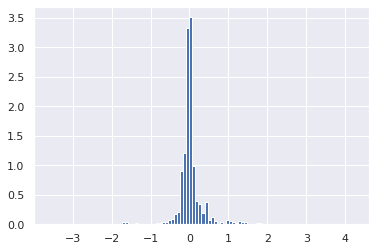

count    8849.000000
mean        0.026589
std         0.354909
min        -3.601676
25%        -0.076032
50%        -0.002365
75%         0.067450
max         4.219189
Name: ret_-1, dtype: float64

In [157]:
ret_class = 'ret_-1'
dfg = df.copy()
dfg.shape[0]

fig, ax = plt.subplots()

_ = ax.hist(dfg[ret_class].values, bins=100, density=True)
plt.show()

dfg[ret_class].describe()

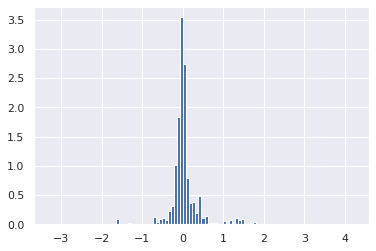

count    4054.000000
mean        0.039184
std         0.376907
min        -3.294021
25%        -0.075426
50%        -0.000943
75%         0.073230
max         4.219189
Name: ret_-1, dtype: float64

In [160]:
dfg = df.loc[(df['buy']>0)]

buy = dfg['buy'].values
ret = dfg[ret_class].values

fig, ax = plt.subplots()

_ = ax.hist(ret,bins=100, density=True)
plt.show()

df.loc[(df['buy'] >0)][ret_class].describe()

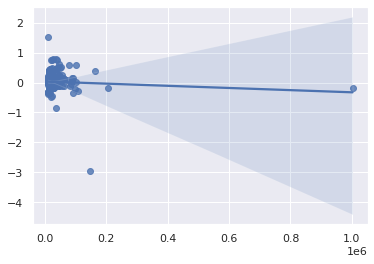

In [68]:
ax = sns.regplot(x=buy, y=ret)

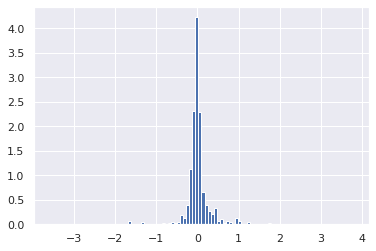

count    4795.000000
mean        0.015941
std         0.334857
min        -3.601676
25%        -0.077307
50%        -0.003438
75%         0.060016
max         3.798933
Name: ret_-1, dtype: float64

In [161]:
dfg = df.loc[(df['buy']<0)]

buy = dfg['buy'].values
ret = dfg[ret_class].values

fig, ax = plt.subplots()

_ = ax.hist(ret,bins=100, density=True)
plt.show()

df.loc[(df['buy'] <0)][ret_class].describe()

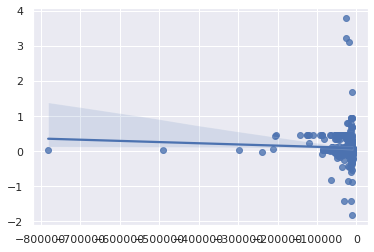

In [88]:
ax = sns.regplot(x=buy, y=ret)

## Exclude First Ten Days

In [135]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['date'] = df['timestamp'].dt.strftime('%Y-%m-%d')
df['date'] = pd.to_datetime(df['date'])
dfs = []

for idx, row in df.drop_duplicates(['contractAddress']).iterrows():
    try:
        chain = row['chain']
        insider_contractAddress = row['contractAddress']
        first_day = pd.to_datetime(token_first_day(contract=insider_contractAddress,
                                                   chain=chain))
        ten_day = pd.to_datetime(first_day + datetime.timedelta(days=9))

        dfs.append(df.loc[(df['contractAddress'] == insider_contractAddress)&
                          (df['date'] > ten_day)])
    except Exception as e:
        print('e')
dfs = pd.concat(dfs)
dfs

e


,Unnamed: 0,amountUSD,id,logIndex,origin,recipient,sender,sqrtPriceX96,tick,timestamp,token0_name,token1_name,token0_id,token1_id,transaction_id,amount0Out,amount0In,amount1Out,amount1In,home_token,dex,chain,insider_root,contractAddress,from,to,lp,buy,ret_1,ret_2,ret_3,ret_-1,ret_-2,ret_-3,date
0,0,209.294150,0xe91b835550a1a50b26a0646fa3e1def942a78ea5ce7349529a30700eff08ab11#33823,266,0x008295a98dcd428b680bc1db7a743f1d3993b4d4,0x008295a98dcd428b680bc1db7a743f1d3993b4d4,0xe592427a0aece92de3edee1f18e0157c05861564,9400732126353364784919992,-180796.0,2021-11-22 02:43:11,Tiger King,Wrapped Ether,0x24e89bdf2f65326b94e36978a7edeac63623dafa,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0xe91b835550a1a50b26a0646fa3e1def942a78ea5ce7349529a30700eff08ab11,3.541485e+06,0.000000e+00,0.000000,0.05,True,uniswapv3_ethereum,ethereum,0x008295a98dcd428b680bc1db7a743f1d3993b4d4,0x24e89bdf2f65326b94e36978a7edeac63623dafa,NaN,NaN,False,209.294150,0.026956,-0.143178,-0.102227,-0.580864,-0.503014,-0.738577,2021-11-22
25,25,7562.322967,0x26d7f78fd52f48993d467b34cf8d3e02401cde45bd388627423539156498cf1e#33787,589,0x096dc50cdcdcd72b39c1835a99f51f0154c2b994,0x096dc50cdcdcd72b39c1835a99f51f0154c2b994,0xe592427a0aece92de3edee1f18e0157c05861564,8507979601983770607655828,-182791.0,2021-11-22 02:17:15,Tiger King,Wrapped Ether,0x24e89bdf2f65326b94e36978a7edeac63623dafa,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x26d7f78fd52f48993d467b34cf8d3e02401cde45bd388627423539156498cf1e,1.568355e+08,0.000000e+00,0.000000,1.80,True,uniswapv3_ethereum,ethereum,0x096dc50cdcdcd72b39c1835a99f51f0154c2b994,0x24e89bdf2f65326b94e36978a7edeac63623dafa,NaN,NaN,False,7562.322967,0.026956,-0.143178,-0.102227,-0.580864,-0.503014,-0.738577,2021-11-22
26,26,3352.758275,0x2c0b995bfa0be0b31e7d01ba462fda85976da344284d1e5e9582b6546eb185d3#33793,468,0x096dc50cdcdcd72b39c1835a99f51f0154c2b994,0x096dc50cdcdcd72b39c1835a99f51f0154c2b994,0xe592427a0aece92de3edee1f18e0157c05861564,8658921329860525795529063,-182440.0,2021-11-22 02:24:46,Tiger King,Wrapped Ether,0x24e89bdf2f65326b94e36978a7edeac63623dafa,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x2c0b995bfa0be0b31e7d01ba462fda85976da344284d1e5e9582b6546eb185d3,6.700160e+07,0.000000e+00,0.000000,0.80,True,uniswapv3_ethereum,ethereum,0x096dc50cdcdcd72b39c1835a99f51f0154c2b994,0x24e89bdf2f65326b94e36978a7edeac63623dafa,NaN,NaN,False,3352.758275,0.026956,-0.143178,-0.102227,-0.580864,-0.503014,-0.738577,2021-11-22
27,27,4216.133471,0x6e652d3a51857ca78cfd868e614bccd854aaeae3a49654963ae5998f3004964f#33782,302,0x096dc50cdcdcd72b39c1835a99f51f0154c2b994,0x096dc50cdcdcd72b39c1835a99f51f0154c2b994,0xe592427a0aece92de3edee1f18e0157c05861564,8214758198753843217623571,-183493.0,2021-11-22 02:13:28,Tiger King,Wrapped Ether,0x24e89bdf2f65326b94e36978a7edeac63623dafa,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x6e652d3a51857ca78cfd868e614bccd854aaeae3a49654963ae5998f3004964f,9.315383e+07,0.000000e+00,0.000000,1.00,True,uniswapv3_ethereum,ethereum,0x096dc50cdcdcd72b39c1835a99f51f0154c2b994,0x24e89bdf2f65326b94e36978a7edeac63623dafa,NaN,NaN,False,4216.133471,0.026956,-0.143178,-0.102227,-0.580864,-0.503014,-0.738577,2021-11-22
28,28,13166.313081,0xade936aeefabbded54b7dfd02b34cf83faca3d131c5aa767c0ce4f01eb3b8122#34011,21,0x096dc50cdcdcd72b39c1835a99f51f0154c2b994,0xe592427a0aece92de3edee1f18e0157c05861564,0xe592427a0aece92de3edee1f18e0157c05861564,7944297213366174837631690,-184162.0,2021-11-22 22:13:36,Tiger King,Wrapped Ether,0x24e89bdf2f65326b94e36978a7edeac63623dafa,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0xade936aeefabbded54b7dfd02b34cf83faca3d131c5aa767c0ce4f01eb3b8122,0.000000e+00,3.169909e+08,3.224831,0.00,True,uniswapv3_ethereum,ethereum,0x096dc50cdcdcd72b39c1835a99f51f0154c2b994,0x24e89bdf2f65326b94e36978a7edeac63623dafa,NaN,NaN,False,-13166.313081,0.026956,-0.143178,-0.102227,-0.580864,-0.503014,-0.738577,2021-11-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

15470

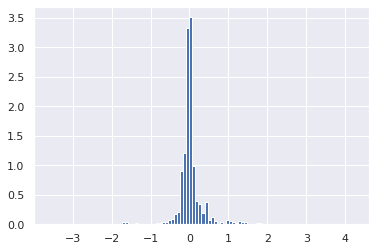

count    8849.000000
mean        0.026589
std         0.354909
min        -3.601676
25%        -0.076032
50%        -0.002365
75%         0.067450
max         4.219189
Name: ret_-1, dtype: float64

In [139]:
ret_class = 'ret_-1'
dfg = df.copy()
dfg.shape[0]

fig, ax = plt.subplots()

_ = ax.hist(dfg[ret_class].values, bins=100, density=True)
plt.show()

dfg[ret_class].describe()

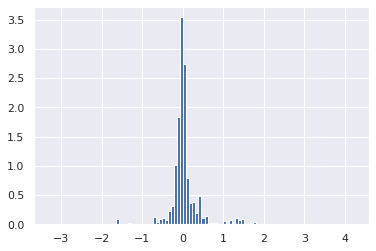

count    4054.000000
mean        0.039184
std         0.376907
min        -3.294021
25%        -0.075426
50%        -0.000943
75%         0.073230
max         4.219189
Name: ret_-1, dtype: float64

In [140]:
dfg = df.loc[(df['buy']>0)]

buy = dfg['buy'].values
ret = dfg[ret_class].values

fig, ax = plt.subplots()

_ = ax.hist(ret,bins=100, density=True)
plt.show()

df.loc[(df['buy'] >0)][ret_class].describe()

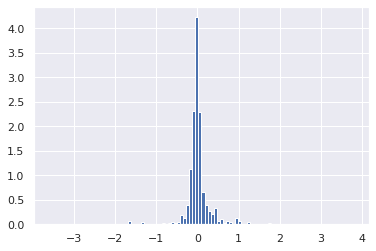

count    4795.000000
mean        0.015941
std         0.334857
min        -3.601676
25%        -0.077307
50%        -0.003438
75%         0.060016
max         3.798933
Name: ret_-1, dtype: float64

In [141]:
dfg = df.loc[(df['buy']<0)]

buy = dfg['buy'].values
ret = dfg[ret_class].values

fig, ax = plt.subplots()

_ = ax.hist(ret,bins=100, density=True)
plt.show()

df.loc[(df['buy'] <0)][ret_class].describe()